<a href="https://colab.research.google.com/github/krishnaaa-7/Resume-Relevance-Checker-System/blob/main/Resume_Relevance_Checker_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q sentence-transformers transformers pdfplumber python-docx docx2txt rapidfuzz faiss-cpu


In [2]:
import os
import re
import json
import math
from typing import List, Dict, Tuple
import numpy as np
import pdfplumber
import docx2txt
from rapidfuzz import fuzz, process
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

In [3]:
# 3) Utilities: text extraction
def extract_text_from_pdf(path: str) -> str:
    texts = []
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            txt = page.extract_text()
            if txt:
                texts.append(txt)
    return "\n".join(texts)

def extract_text_from_docx(path: str) -> str:
    return docx2txt.process(path)

def extract_text(path: str) -> str:
    ext = path.lower().split('.')[-1]
    if ext == 'pdf':
        return extract_text_from_pdf(path)
    elif ext in ('docx', 'doc'):
        return extract_text_from_docx(path)
    else:
        raise ValueError("Unsupported file type: " + ext)


In [4]:
# 4) Preprocessing
def normalize_text(text: str) -> str:
    text = re.sub(r'\r\n', '\n', text)
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


In [5]:
# 5) Lightweight section extraction heuristics (Skills / Education / Projects)
SECTION_HEADINGS = [
    r'\bskills\b', r'\btechnical skills\b', r'\bprogramming skills\b',
    r'\beducation\b', r'\bprojects\b', r'\bexperience\b', r'\bcertifications\b'
]

def find_sections(text: str) -> Dict[str,str]:
    # Very simple heuristic: split by common headings
    # returns dict of heading -> content
    lower = text.lower()
    # find indices of headings
    headings_pos = []
    for h in SECTION_HEADINGS:
        for m in re.finditer(h, lower):
            headings_pos.append((m.start(), m.group()))
    headings_pos.sort()
    sections = {}
    if not headings_pos:
        sections['full'] = text
        return sections
    # boundaries
    for i, (pos, head) in enumerate(headings_pos):
        start = pos
        end = headings_pos[i+1][0] if i+1 < len(headings_pos) else len(text)
        name = re.sub(r'[^a-z ]','', head).strip()
        content = text[start:end]
        sections[name] = content
    # add full text
    sections['full'] = text
    return sections


In [6]:
# 6) Skill extraction by matching against a skill-list (can be extended)
# We'll provide a default skill list; in production load from curated DB.
DEFAULT_SKILLS = [
    "python","java","c++","c","c#","sql","nosql","mongodb","postgresql","mysql",
    "tensorflow","pytorch","keras","scikit-learn","transformers","nlp","computer vision",
    "cv","docker","kubernetes","aws","azure","gcp","rest api","fastapi","flask",
    "git","linux","spark","hadoop","pandas","numpy","matplotlib","seaborn",
    "react","nodejs","javascript","html","css","bash","shell","opencv"
]

def extract_skills_from_text(text: str, skill_list: List[str]=None) -> List[str]:
    if skill_list is None:
        skill_list = DEFAULT_SKILLS
    found = set()
    lower = text.lower()
    for skill in skill_list:
        if re.search(r'\b' + re.escape(skill.lower()) + r'\b', lower):
            found.add(skill)
    # also capture candidate-defined ones using fuzzy token matching
    tokens = re.findall(r'[A-Za-z\+#\.\-]{2,}', text)
    for tok in set(tokens):
        # Use try-except to handle potential issues with extractOne returning more than 2 values
        try:
            match, score = process.extractOne(tok.lower(), skill_list, scorer=fuzz.partial_ratio)
            if score and score >= 90:
                found.add(match)
        except ValueError:
            # If extractOne returns more than 2 values, skip this token or handle as needed
            continue
    return sorted(found)

In [7]:
# 7) JD parsing: heuristics to pull required and nice-to-have
def parse_jd(jd_text: str) -> Dict[str, List[str]]:
    jd_lower = jd_text.lower()
    # Try to find "must have / required" lists
    required = []
    nice = []
    # Common patterns
    required_patterns = [r'(must have|must|required|requirements:|required skills:|responsibilities:)',]
    nice_patterns = [r'(nice to have|good to have|preferred|preferred qualifications)',]
    # split lines and attempt to classify lines
    lines = [l.strip() for l in jd_text.splitlines() if l.strip()]
    cur_bucket = None
    for line in lines:
        ll = line.lower()
        if any(p in ll for p in required_patterns):
            cur_bucket = 'required'
            continue
        if any(p in ll for p in nice_patterns):
            cur_bucket = 'nice'
            continue
        # bullets or comma-separated
        if line.startswith('-') or line.startswith('*') or len(line.split())<12:
            bucket = cur_bucket if cur_bucket else 'required'  # default assume required
            if bucket == 'required':
                required.append(line.strip('-* ').strip())
            else:
                nice.append(line.strip('-* ').strip())
        else:
            # longer sentences, also try to extract skills using our skill list
            # fallback: gather any skill words
            pass
    # additionally, extract skills from whole JD text
    jd_skills = extract_skills_from_text(jd_text)
    # if we couldn't parse bullets, use jd_skills as required
    if not required and jd_skills:
        required = jd_skills
    # rudimentary cleaning (split comma lists)
    def split_items(items):
        out=[]
        for it in items:
            for part in re.split(r'[;,/]| or |\band\b', it):
                p = part.strip()
                if p:
                    out.append(p)
        return list(dict.fromkeys(out))
    required = split_items(required)
    nice = split_items(nice)
    return {"required": required, "nice_to_have": nice, "skills": jd_skills}


In [10]:
# 8) Embeddings setup (SentenceTransformers)
EMBED_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
embed_model = SentenceTransformer(EMBED_MODEL_NAME)

def get_embedding(text: str):
    return embed_model.encode(text, convert_to_tensor=True)


In [11]:
# 9) Matching & scoring
from numpy.linalg import norm

def cosine_sim_vec(a, b):
    a = np.array(a)
    b = np.array(b)
    if np.all(a==0) or np.all(b==0):
        return 0.0
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def hard_match_score(jd_required: List[str], resume_text: str) -> Tuple[float, List[str], List[Tuple[str,float]]]:
    """
    Returns: score between 0-100, list of missing required items, list of (matched_item, score)
    We use fuzzy matching for resilience.
    """
    resume_lower = resume_text.lower()
    matched = []
    missing = []
    matched_scores = []
    for req in jd_required:
        req_clean = req.strip().lower()
        # exact word presence?
        if re.search(r'\b' + re.escape(req_clean) + r'\b', resume_lower):
            matched.append(req)
            matched_scores.append((req, 100.0))
            continue
        # fuzzy search for tokens
        tokens = re.findall(r'[A-Za-z\+#\.\-]{2,}', req_clean)
        # take highest fuzzy match across resume text tokens
        score = 0
        for tok in tokens:
            s = fuzz.partial_ratio(tok, resume_lower)
            if s>score:
                score = s
        if score >= 75:
            matched.append(req)
            matched_scores.append((req, float(score)))
        else:
            missing.append(req)
    # Score = matched_count / total_required * 100, weighted by fuzzy score
    if not jd_required:
        return 0.0, [], []
    weighted = 0.0
    for m, sc in matched_scores:
        weighted += sc/100.0
    hard_score = (weighted / len(jd_required)) * 100.0
    return round(hard_score,2), missing, matched_scores

def semantic_score(jd_text: str, resume_text: str) -> float:
    # embed full jd and resume
    e_jd = embed_model.encode(jd_text, convert_to_tensor=True)
    e_res = embed_model.encode(resume_text, convert_to_tensor=True)
    sim = util.pytorch_cos_sim(e_jd, e_res).item()
    return round(sim * 100.0, 2)  # convert 0-1 -> 0-100


In [12]:
# 10) Weighted scoring formula and verdict
def compute_final_score(hard: float, semantic: float, weights: Dict[str,float]=None):
    # default weights: hard 0.6, semantic 0.4
    if weights is None:
        weights = {"hard": 0.6, "semantic": 0.4}
    final = hard*weights['hard'] + semantic*weights['semantic']
    return round(final, 2)

def verdict_from_score(score: float):
    if score >= 75:
        return "High"
    elif score >= 50:
        return "Medium"
    else:
        return "Low"

In [13]:
# 11) LLM-based improvement suggestion (uses HF pipeline; small model by default)
# Note: you can swap model name to a larger LLM if needed.
GEN_MODEL = "google/flan-t5-small"  # compact; swap to flan-t5-base for better output
gen_pipeline = pipeline("text2text-generation", model=GEN_MODEL, device=-1)  # CPU default; in Colab you can set device=0 for GPU

def generate_suggestions(jd_text: str, resume_text: str, missing_skills: List[str], top_k:int=5) -> str:
    prompt = (
        "You are an expert career coach. Given the job description and a candidate resume, produce:\n"
        "1) A concise Relevance summary (1-2 lines),\n"
        "2) Top missing skills/certifications (bullet list),\n"
        "3) Practical improvement actions the candidate can do in 30 / 90 days (bulleted),\n\n"
        "Job description:\n" + jd_text + "\n\n"
        "Candidate resume (short):\n" + (resume_text[:3000] if len(resume_text)>3000 else resume_text) + "\n\n"
        "Missing skills (from hard match): " + (", ".join(missing_skills) if missing_skills else "None") + "\n\n"
        "Produce a compact, actionable output."
    )
    out = gen_pipeline(prompt, max_length=1000, do_sample=False)
    return out[0]['generated_text']


Device set to use cpu


In [14]:
# 12) Full pipeline function
def evaluate_resume_against_jd(resume_path: str, jd_path: str, verbose: bool=True) -> Dict:
    # read files
    resume_text = normalize_text(extract_text(resume_path))
    jd_text = normalize_text(extract_text(jd_path))
    # parse JD
    jd_parsed = parse_jd(jd_text)
    required = jd_parsed.get('required', [])
    nice = jd_parsed.get('nice_to_have', [])
    # hard match
    hard_score, missing_required, matched_scores = hard_match_score(required, resume_text)
    # semantic match
    sem_score = semantic_score(jd_text, resume_text)
    # final score
    final = compute_final_score(hard_score, sem_score)
    verdict = verdict_from_score(final)
    # suggestions using LLM (short)
    suggestions = generate_suggestions(jd_text, resume_text, missing_required)
    result = {
        "resume_path": resume_path,
        "jd_path": jd_path,
        "jd_parsed": jd_parsed,
        "hard_score": hard_score,
        "semantic_score": sem_score,
        "final_score": final,
        "verdict": verdict,
        "missing_required": missing_required,
        "matched_scores": matched_scores,
        "suggestions": suggestions
    }
    if verbose:
        print("Hard score: ", hard_score)
        print("Semantic score: ", sem_score)
        print("Final score: ", final, " Verdict:", verdict)
        print("Missing required items:", missing_required)
    return result

In [20]:
from google.colab import files

# Upload Resume file
print("📄 Please upload the resume file (PDF/DOCX/TXT):")
resume_upload = files.upload()



📄 Please upload the resume file (PDF/DOCX/TXT):


Saving Sreeram Venkata Phani Kiranmai Resume.docx to Sreeram Venkata Phani Kiranmai Resume (1).docx


In [25]:
# Upload JD file
print("📄 Please upload the Job Description file (PDF/DOCX/TXT):")
jd_upload = files.upload()



📄 Please upload the Job Description file (PDF/DOCX/TXT):


Saving sample_jd_2 (1).pdf to sample_jd_2 (1) (4).pdf


In [26]:
# Get file names (first uploaded in each step)
resume_path = list(resume_upload.keys())[0]
jd_path = list(jd_upload.keys())[0]




In [27]:
# Run the evaluation
result = evaluate_resume_against_jd(resume_path, jd_path)



Both `max_new_tokens` (=256) and `max_length`(=1000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Hard score:  62.5
Semantic score:  35.04
Final score:  51.52  Verdict: Medium
Missing required items: ['c', 'nlp', 'spark']


In [28]:
# Display structured result
import pprint
pprint.pprint(result)

{'final_score': 51.52,
 'hard_score': 62.5,
 'jd_parsed': {'nice_to_have': [],
               'required': ['c',
                            'computer vision',
                            'nlp',
                            'numpy',
                            'pandas',
                            'python',
                            'spark',
                            'sql'],
               'skills': ['c',
                          'computer vision',
                          'nlp',
                          'numpy',
                          'pandas',
                          'python',
                          'spark',
                          'sql']},
 'jd_path': 'sample_jd_2 (1) (4).pdf',
 'matched_scores': [('computer vision', 100.0),
                    ('numpy', 100.0),
                    ('pandas', 100.0),
                    ('python', 100.0),
                    ('sql', 100.0)],
 'missing_required': ['c', 'nlp', 'spark'],
 'resume_path': 'Sreeram Venkata Phani Kiranmai Re

In [29]:
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt

def display_results(result):
    # Title
    display(HTML("<h2 style='color:#2E86C1'>📊 Resume Relevance Evaluation Result</h2>"))

    # Gauge Chart for Final Score
    fig, ax = plt.subplots(figsize=(5, 1.2))
    ax.barh(0, result['final_score'], color="green" if result['verdict']=="High" else "orange" if result['verdict']=="Medium" else "red")
    ax.set_xlim(0, 100)
    ax.set_yticks([])
    ax.set_title(f"Final Score: {result['final_score']}%", fontsize=12, pad=10)
    plt.show()

    # Verdict Box
    verdict_color = "green" if result['verdict']=="High" else "orange" if result['verdict']=="Medium" else "red"
    verdict_html = f"""
    <div style="border:2px solid {verdict_color}; padding:15px; border-radius:10px; background:#F8F9F9;">
        <h3>Final Verdict: <span style="color:{verdict_color};">{result['verdict']}</span></h3>
        <p><b>Hard Match Score:</b> {result['hard_score']}%</p>
        <p><b>Semantic Similarity:</b> {result['semantic_score']}%</p>
    </div>
    """
    display(HTML(verdict_html))

    # Missing skills
    if result['missing_required']:
        missing_df = pd.DataFrame(result['missing_required'], columns=["🚨 Missing Required Skills"])
        display(missing_df.style.set_properties(**{'background-color': '#FADBD8'}))
    else:
        display(HTML("<p style='color:green; font-weight:bold;'>✅ No required skills missing!</p>"))

    # Suggestions
    display(HTML("<h3 style='color:#117A65'>💡 Suggested Improvements</h3>"))
    display(HTML(f"<div style='white-space:pre-wrap; background:#EBF5FB; padding:10px; border-radius:10px;'>{result['suggestions']}</div>"))


In [30]:
%%writefile evaluate.py
import os
import re
import json
import math
from typing import List, Dict, Tuple
import numpy as np
import pdfplumber
import docx2txt
from rapidfuzz import fuzz, process
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

# 3) Utilities: text extraction
def extract_text_from_pdf(path: str) -> str:
    texts = []
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            txt = page.extract_text()
            if txt:
                texts.append(txt)
    return "\n".join(texts)

def extract_text_from_docx(path: str) -> str:
    return docx2txt.process(path)

def extract_text(path: str) -> str:
    ext = path.lower().split('.')[-1]
    if ext == 'pdf':
        return extract_text_from_pdf(path)
    elif ext in ('docx', 'doc'):
        return extract_text_from_docx(path)
    else:
        raise ValueError("Unsupported file type: " + ext)

# 4) Preprocessing
def normalize_text(text: str) -> str:
    text = re.sub(r'\r\n', '\n', text)
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# 5) Lightweight section extraction heuristics (Skills / Education / Projects)
SECTION_HEADINGS = [
    r'\bskills\b', r'\btechnical skills\b', r'\bprogramming skills\b',
    r'\beducation\b', r'\bprojects\b', r'\bexperience\b', r'\bcertifications\b'
]

def find_sections(text: str) -> Dict[str,str]:
    # Very simple heuristic: split by common headings
    # returns dict of heading -> content
    lower = text.lower()
    # find indices of headings
    headings_pos = []
    for h in SECTION_HEADINGS:
        for m in re.finditer(h, lower):
            headings_pos.append((m.start(), m.group()))
    headings_pos.sort()
    sections = {}
    if not headings_pos:
        sections['full'] = text
        return sections
    # boundaries
    for i, (pos, head) in enumerate(headings_pos):
        start = pos
        end = headings_pos[i+1][0] if i+1 < len(headings_pos) else len(text)
        name = re.sub(r'[^a-z ]','', head).strip()
        content = text[start:end]
        sections[name] = content
    # add full text
    sections['full'] = text
    return sections

# 6) Skill extraction by matching against a skill-list (can be extended)
# We'll provide a default skill list; in production load from curated DB.
DEFAULT_SKILLS = [
    "python","java","c++","c","c#","sql","nosql","mongodb","postgresql","mysql",
    "tensorflow","pytorch","keras","scikit-learn","transformers","nlp","computer vision",
    "cv","docker","kubernetes","aws","azure","gcp","rest api","fastapi","flask",
    "git","linux","spark","hadoop","pandas","numpy","matplotlib","seaborn",
    "react","nodejs","javascript","html","css","bash","shell","opencv"
]

def extract_skills_from_text(text: str, skill_list: List[str]=None) -> List[str]:
    if skill_list is None:
        skill_list = DEFAULT_SKILLS
    found = set()
    lower = text.lower() # Ensure this is 'lower'
    for skill in skill_list:
        if re.search(r'\b' + re.escape(skill.lower()) + r'\b', lower): # Use 'lower' here
            found.add(skill)
    # also capture candidate-defined ones using fuzzy token matching
    tokens = re.findall(r'[A-Za-z\+#\.\-]{2,}', text)
    for tok in set(tokens):
        # Use try-except to handle potential issues with extractOne returning more than 2 values
        try:
            # Ensure 'lower' is used in the fuzzy matching context if needed, but here it's tok.lower() vs skill_list
            match, score = process.extractOne(tok.lower(), skill_list, scorer=fuzz.partial_ratio)
            if score and score >= 90:
                found.add(match)
        except ValueError:
            # If extractOne returns more than 2 values, skip this token or handle as needed
            continue
    return sorted(found)

# 7) JD parsing: heuristics to pull required and nice-to-have
def parse_jd(jd_text: str) -> Dict[str, List[str]]:
    jd_lower = jd_text.lower()
    # Try to find "must have / required" lists
    required = []
    nice = []
    # Common patterns
    required_patterns = [r'(must have|must|required|requirements:|required skills:|responsibilities:)',]
    nice_patterns = [r'(nice to have|good to have|preferred|preferred qualifications)',]
    # split lines and attempt to classify lines
    lines = [l.strip() for l in jd_text.splitlines() if l.strip()]
    cur_bucket = None
    for line in lines:
        ll = line.lower()
        if any(p in ll for p in required_patterns):
            cur_bucket = 'required'
            continue
        if any(p in ll for p in nice_patterns):
            cur_bucket = 'nice'
            continue
        # bullets or comma-separated
        if line.startswith('-') or line.startswith('*') or len(line.split())<12:
            bucket = cur_bucket if cur_bucket else 'required'  # default assume required
            if bucket == 'required':
                required.append(line.strip('-* ').strip())
            else:
                nice.append(line.strip('-* ').strip())
        else:
            # longer sentences, also try to extract skills using our skill list
            # fallback: gather any skill words
            pass
    # additionally, extract skills from whole JD text
    jd_skills = extract_skills_from_text(jd_text)
    # if we couldn't parse bullets, use jd_skills as required
    if not required and jd_skills:
        required = jd_skills
    # rudimentary cleaning (split comma lists)
    def split_items(items):
        out=[]
        for it in items:
            for part in re.split(r'[;,/]| or |\band\b', it):
                p = part.strip()
                if p:
                    out.append(p)
        return list(dict.fromkeys(out))
    required = split_items(required)
    nice = split_items(nice)
    return {"required": required, "nice_to_have": nice, "skills": jd_skills}

# 8) Embeddings setup (SentenceTransformers)
EMBED_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
embed_model = SentenceTransformer(EMBED_MODEL_NAME)

def get_embedding(text: str):
    return embed_model.encode(text, convert_to_tensor=True)

# 9) Matching & scoring
from numpy.linalg import norm

def cosine_sim_vec(a, b):
    a = np.array(a)
    b = np.array(b)
    if np.all(a==0) or np.all(b==0):
        return 0.0
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def hard_match_score(jd_required: List[str], resume_text: str) -> Tuple[float, List[str], List[Tuple[str,float]]]:
    """
    Returns: score between 0-100, list of missing required items, list of (matched_item, score)
    We use fuzzy matching for resilience.
    """
    resume_lower = resume_text.lower() # This variable name is correct here
    matched = []
    missing = []
    matched_scores = []
    for req in jd_required:
        req_clean = req.strip().lower()
        # exact word presence?
        if re.search(r'\b' + re.escape(req_clean) + r'\b', resume_lower):
            matched.append(req)
            matched_scores.append((req, 100.0))
            continue
        # fuzzy search for tokens
        tokens = re.findall(r'[A-Za-z\+#\.\-]{2,}', req_clean)
        # take highest fuzzy match across resume text tokens
        score = 0
        for tok in tokens:
            s = fuzz.partial_ratio(tok, resume_lower) # This uses resume_lower, which is correct in THIS function
            if s>score:
                score = s
        if score >= 75:
            matched.append(req)
            matched_scores.append((req, float(score)))
        else:
            missing.append(req)
    # Score = matched_count / total_required * 100, weighted by fuzzy score
    if not jd_required:
        return 0.0, [], []
    weighted = 0.0
    for m, sc in matched_scores:
        weighted += sc/100.0
    hard_score = (weighted / len(jd_required)) * 100.0
    return round(hard_score,2), missing, matched_scores

def semantic_score(jd_text: str, resume_text: str) -> float:
    # embed full jd and resume
    e_jd = embed_model.encode(jd_text, convert_to_tensor=True)
    e_res = embed_model.encode(resume_text, convert_to_tensor=True)
    sim = util.pytorch_cos_sim(e_jd, e_res).item()
    return round(sim * 100.0, 2)  # convert 0-1 -> 0-100

# 10) Weighted scoring formula and verdict
def compute_final_score(hard: float, semantic: float, weights: Dict[str,float]=None):
    # default weights: hard 0.6, semantic 0.4
    if weights is None:
        weights = {"hard": 0.6, "semantic": 0.4}
    final = hard*weights['hard'] + semantic*weights['semantic']
    return round(final, 2)

def verdict_from_score(score: float):
    if score >= 75:
        return "High"
    elif score >= 50:
        return "Medium"
    else:
        return "Low"

# 11) LLM-based improvement suggestion (uses HF pipeline; small model by default)
# Note: you can swap model name to a larger LLM if needed.
GEN_MODEL = "google/flan-t5-small"  # compact; swap to flan-t5-base for better output
gen_pipeline = pipeline("text2text-generation", model=GEN_MODEL)

def generate_suggestions(jd_text: str, resume_text: str, missing_skills: List[str]) -> str:
    prompt = (
        "You are an expert career coach. Given the job description and a candidate resume, produce:\n"
        "1) A concise Relevance summary (1-2 lines),\n"
        "2) Top missing skills/certifications (bullet list),\n"
        "3) Practical improvement actions the candidate can do in 30 / 90 days (bulleted),\n\n"
        "Job description:\n" + jd_text + "\n\n"
        "Candidate resume (short):\n" + (resume_text[:3000] if len(resume_text)>3000 else resume_text) + "\n\n"
        "Missing skills (from hard match): " + (", ".join(missing_skills) if missing_skills else "None") + "\n\n"
        "Produce a compact, actionable output."
    )
    out = gen_pipeline(prompt, max_length=400, do_sample=False)
    return out[0]['generated_text']

# 12) Full pipeline function
def evaluate_resume_against_jd(resume_path: str, jd_path: str, verbose: bool=True) -> Dict:
    # read files
    resume_text = normalize_text(extract_text(resume_path))
    jd_text = normalize_text(extract_text(jd_path))
    # parse JD
    jd_parsed = parse_jd(jd_text)
    required = jd_parsed.get('required', [])
    nice = jd_parsed.get('nice_to_have', [])
    # hard match
    hard_score, missing_required, matched_scores = hard_match_score(required, resume_text)
    # semantic match
    sem_score = semantic_score(jd_text, resume_text)
    # final score
    final = compute_final_score(hard_score, sem_score)
    verdict = verdict_from_score(final)
    # suggestions using LLM (short)
    suggestions = generate_suggestions(jd_text, resume_text, missing_required)
    result = {
        "resume_path": resume_path,
        "jd_path": jd_path,
        "jd_parsed": jd_parsed,
        "hard_score": hard_score,
        "semantic_score": sem_score,
        "final_score": final,
        "verdict": verdict,
        "missing_required": missing_required,
        "matched_scores": matched_scores,
        "suggestions": suggestions
    }
    if verbose:
        print("Hard score: ", hard_score)
        print("Semantic score: ", sem_score)
        print("Final score: ", final, " Verdict:", verdict)
        print("Missing required items:", missing_required)
    return result

Overwriting evaluate.py


In [31]:
%%writefile app.py
# Save this as app.py and run: streamlit run app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# Include the content of evaluate.py here
import os
import re
import json
import math
from typing import List, Dict, Tuple
import numpy as np
import pdfplumber
import docx2txt
from rapidfuzz import fuzz, process
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

# 3) Utilities: text extraction
def extract_text_from_pdf(path: str) -> str:
    texts = []
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            txt = page.extract_text()
            if txt:
                texts.append(txt)
    return "\n".join(texts)

def extract_text_from_docx(path: str) -> str:
    return docx2txt.process(path)

def extract_text(path: str) -> str:
    ext = path.lower().split('.')[-1]
    if ext == 'pdf':
        return extract_text_from_pdf(path)
    elif ext in ('docx', 'doc'):
        return extract_text_from_docx(path)
    else:
        raise ValueError("Unsupported file type: " + ext)

# 4) Preprocessing
def normalize_text(text: str) -> str:
    text = re.sub(r'\r\n', '\n', text)
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# 5) Lightweight section extraction heuristics (Skills / Education / Projects)
SECTION_HEADINGS = [
    r'\bskills\b', r'\btechnical skills\b', r'\bprogramming skills\b',
    r'\beducation\b', r'\bprojects\b', r'\bexperience\b', r'\bcertifications\b'
]

def find_sections(text: str) -> Dict[str,str]:
    # Very simple heuristic: split by common headings
    # returns dict of heading -> content
    lower = text.lower()
    # find indices of headings
    headings_pos = []
    for h in SECTION_HEADINGS:
        for m in re.finditer(h, lower):
            headings_pos.append((m.start(), m.group()))
    headings_pos.sort()
    sections = {}
    if not headings_pos:
        sections['full'] = text
        return sections
    # boundaries
    for i, (pos, head) in enumerate(headings_pos):
        start = pos
        end = headings_pos[i+1][0] if i+1 < len(headings_pos) else len(text)
        name = re.sub(r'[^a-z ]','', head).strip()
        content = text[start:end]
        sections[name] = content
    # add full text
    sections['full'] = text
    return sections

# 6) Skill extraction by matching against a skill-list (can be extended)
# We'll provide a default skill list; in production load from curated DB.
DEFAULT_SKILLS = [
    "python","java","c++","c","c#","sql","nosql","mongodb","postgresql","mysql",
    "tensorflow","pytorch","keras","scikit-learn","transformers","nlp","computer vision",
    "cv","docker","kubernetes","aws","azure","gcp","rest api","fastapi","flask",
    "git","linux","spark","hadoop","pandas","numpy","matplotlib","seaborn",
    "react","nodejs","javascript","html","css","bash","shell","opencv"
]

def extract_skills_from_text(text: str, skill_list: List[str]=None) -> List[str]:
    if skill_list is None:
        skill_list = DEFAULT_SKILLS
    found = set()
    lower = text.lower() # Ensure this is 'lower'
    for skill in skill_list:
        if re.search(r'\b' + re.escape(skill.lower()) + r'\b', lower): # Use 'lower' here
            found.add(skill)
    # also capture candidate-defined ones using fuzzy token matching
    tokens = re.findall(r'[A-Za-z\+#\.\-]{2,}', text)
    for tok in set(tokens):
        # Use try-except to handle potential issues with extractOne returning more than 2 values
        try:
            # Ensure 'lower' is used in the fuzzy matching context if needed, but here it's tok.lower() vs skill_list
            match, score = process.extractOne(tok.lower(), skill_list, scorer=fuzz.partial_ratio)
            if score and score >= 90:
                found.add(match)
        except ValueError:
            # If extractOne returns more than 2 values, skip this token or handle as needed
            continue
    return sorted(found)

# 7) JD parsing: heuristics to pull required and nice-to-have
def parse_jd(jd_text: str) -> Dict[str, List[str]]:
    jd_lower = jd_text.lower()
    # Try to find "must have / required" lists
    required = []
    nice = []
    # Common patterns
    required_patterns = [r'(must have|must|required|requirements:|required skills:|responsibilities:)',]
    nice_patterns = [r'(nice to have|good to have|preferred|preferred qualifications)',]
    # split lines and attempt to classify lines
    lines = [l.strip() for l in jd_text.splitlines() if l.strip()]
    cur_bucket = None
    for line in lines:
        ll = line.lower()
        if any(p in ll for p in required_patterns):
            cur_bucket = 'required'
            continue
        if any(p in ll for p in nice_patterns):
            cur_bucket = 'nice'
            continue
        # bullets or comma-separated
        if line.startswith('-') or line.startswith('*') or len(line.split())<12:
            bucket = cur_bucket if cur_bucket else 'required'  # default assume required
            if bucket == 'required':
                required.append(line.strip('-* ').strip())
            else:
                nice.append(line.strip('-* ').strip())
        else:
            # longer sentences, also try to extract skills using our skill list
            # fallback: gather any skill words
            pass
    # additionally, extract skills from whole JD text
    jd_skills = extract_skills_from_text(jd_text)
    # if we couldn't parse bullets, use jd_skills as required
    if not required and jd_skills:
        required = jd_skills
    # rudimentary cleaning (split comma lists)
    def split_items(items):
        out=[]
        for it in items:
            for part in re.split(r'[;,/]| or |\band\b', it):
                p = part.strip()
                if p:
                    out.append(p)
        return list(dict.fromkeys(out))
    required = split_items(required)
    nice = split_items(nice)
    return {"required": required, "nice_to_have": nice, "skills": jd_skills}

# 8) Embeddings setup (SentenceTransformers)
EMBED_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
embed_model = SentenceTransformer(EMBED_MODEL_NAME)

def get_embedding(text: str):
    return embed_model.encode(text, convert_to_tensor=True)

# 9) Matching & scoring
from numpy.linalg import norm

def cosine_sim_vec(a, b):
    a = np.array(a)
    b = np.array(b)
    if np.all(a==0) or np.all(b==0):
        return 0.0
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def hard_match_score(jd_required: List[str], resume_text: str) -> Tuple[float, List[str], List[Tuple[str,float]]]:
    """
    Returns: score between 0-100, list of missing required items, list of (matched_item, score)
    We use fuzzy matching for resilience.
    """
    resume_lower = resume_text.lower() # This variable name is correct here
    matched = []
    missing = []
    matched_scores = []
    for req in jd_required:
        req_clean = req.strip().lower()
        # exact word presence?
        if re.search(r'\b' + re.escape(req_clean) + r'\b', resume_lower):
            matched.append(req)
            matched_scores.append((req, 100.0))
            continue
        # fuzzy search for tokens
        tokens = re.findall(r'[A-Za-z\+#\.\-]{2,}', req_clean)
        # take highest fuzzy match across resume text tokens
        score = 0
        for tok in tokens:
            s = fuzz.partial_ratio(tok, resume_lower) # This uses resume_lower, which is correct in THIS function
            if s>score:
                score = s
        if score >= 75:
            matched.append(req)
            matched_scores.append((req, float(score)))
        else:
            missing.append(req)
    # Score = matched_count / total_required * 100, weighted by fuzzy score
    if not jd_required:
        return 0.0, [], []
    weighted = 0.0
    for m, sc in matched_scores:
        weighted += sc/100.0
    hard_score = (weighted / len(jd_required)) * 100.0
    return round(hard_score,2), missing, matched_scores

def semantic_score(jd_text: str, resume_text: str) -> float:
    # embed full jd and resume
    e_jd = embed_model.encode(jd_text, convert_to_tensor=True)
    e_res = embed_model.encode(resume_text, convert_to_tensor=True)
    sim = util.pytorch_cos_sim(e_jd, e_res).item()
    return round(sim * 100.0, 2)  # convert 0-1 -> 0-100

# 10) Weighted scoring formula and verdict
def compute_final_score(hard: float, semantic: float, weights: Dict[str,float]=None):
    # default weights: hard 0.6, semantic 0.4
    if weights is None:
        weights = {"hard": 0.6, "semantic": 0.4}
    final = hard*weights['hard'] + semantic*weights['semantic']
    return round(final, 2)

def verdict_from_score(score: float):
    if score >= 75:
        return "High"
    elif score >= 50:
        return "Medium"
    else:
        return "Low"

# 11) LLM-based improvement suggestion (uses HF pipeline; small model by default)
# Note: you can swap model name to a larger LLM if needed.
GEN_MODEL = "google/flan-t5-small"  # compact; swap to flan-t5-base for better output
gen_pipeline = pipeline("text2text-generation", model=GEN_MODEL)

def generate_suggestions(jd_text: str, resume_text: str, missing_skills: List[str]) -> str:
    prompt = (
        "You are an expert career coach. Given the job description and a candidate resume, produce:\n"
        "1) A concise Relevance summary (1-2 lines),\n"
        "2) Top missing skills/certifications (bullet list),\n"
        "3) Practical improvement actions the candidate can do in 30 / 90 days (bulleted),\n\n"
        "Job description:\n" + jd_text + "\n\n"
        "Candidate resume (short):\n" + (resume_text[:3000] if len(resume_text)>3000 else resume_text) + "\n\n"
        "Missing skills (from hard match): " + (", ".join(missing_skills) if missing_skills else "None") + "\n\n"
        "Produce a compact, actionable output."
    )
    out = gen_pipeline(prompt, max_length=400, do_sample=False)
    return out[0]['generated_text']

# 12) Full pipeline function (adapted for Streamlit)
def evaluate_resume_against_jd(resume_path: str, jd_path: str, verbose: bool=True) -> Dict:
    # read files
    resume_text = normalize_text(extract_text(resume_path))
    jd_text = normalize_text(extract_text(jd_path))
    # parse JD
    jd_parsed = parse_jd(jd_text)
    required = jd_parsed.get('required', [])
    nice = jd_parsed.get('nice_to_have', [])
    # hard match
    hard_score, missing_required, matched_scores = hard_match_score(required, resume_text)
    # semantic match
    sem_score = semantic_score(jd_text, resume_text)
    # final score
    final = compute_final_score(hard_score, sem_score)
    verdict = verdict_from_score(final)
    # suggestions using LLM (short)
    suggestions = generate_suggestions(jd_text, resume_text, missing_required)
    result = {
        "resume_path": resume_path,
        "jd_path": jd_path,
        "jd_parsed": jd_parsed,
        "hard_score": hard_score,
        "semantic_score": sem_score,
        "final_score": final,
        "verdict": verdict,
        "missing_required": missing_required,
        "matched_scores": matched_scores,
        "suggestions": suggestions
    }
    # In Streamlit app, we don't print verbose output here, Streamlit components handle display
    return result


st.set_page_config(page_title="Resume Relevance Checker", layout="wide")

st.title("📊 Automated Resume Relevance Check System")

# Upload files
resume_file = st.file_uploader("📄 Upload Resume (PDF/DOCX/TXT)", type=["pdf", "docx", "txt"])
jd_file = st.file_uploader("📄 Upload Job Description (PDF/DOCX/TXT)", type=["pdf", "docx", "txt"])

if resume_file and jd_file:
    # Save uploads temporarily
    # Streamlit handles temporary files, we just need the path
    # No need to explicitly save to a new temp file here, Streamlit provides a file-like object
    # We need to get the file content and pass it or save it if extract_text requires a path

    # A common pattern is to save the uploaded file to a temporary location
    # and pass that path to your evaluation function.
    import tempfile

    with tempfile.NamedTemporaryFile(delete=False, suffix=os.path.splitext(resume_file.name)[1]) as tmp_resume_file:
        tmp_resume_file.write(resume_file.getvalue())
        resume_path = tmp_resume_file.name

    with tempfile.NamedTemporaryFile(delete=False, suffix=os.path.splitext(jd_file.name)[1]) as tmp_jd_file:
        tmp_jd_file.write(jd_file.getvalue())
        jd_path = tmp_jd_file.name

    try:
        # Run evaluation
        result = evaluate_resume_against_jd(resume_path, jd_path, verbose=False)

        # Show scores
        st.metric("Hard Match Score", f"{result['hard_score']}%")
        st.metric("Semantic Similarity", f"{result['semantic_score']}%")
        st.metric("Final Score", f"{result['final_score']}%", delta=result['verdict'])

        # Gauge chart
        fig, ax = plt.subplots(figsize=(5,1.2))
        ax.barh(0, result['final_score'], color="green" if result['verdict']=="High" else "orange" if result['verdict']=="Medium" else "red")
        ax.set_xlim(0, 100)
        ax.set_yticks([])
        ax.set_title(f"Final Score: {result['final_score']}%")
        st.pyplot(fig)

        # Missing skills
        if result["missing_required"]:
            st.subheader("🚨 Missing Required Skills")
            st.table(pd.DataFrame(result["missing_required"], columns=["Skill"]))
        else:
            st.success("✅ No required skills missing!")

        # Suggestions
        st.subheader("💡 Suggested Improvements")
        st.info(result["suggestions"])

    finally:
        # Clean up temporary files
        os.remove(resume_path)
        os.remove(jd_path)

Overwriting app.py


In [32]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import os
import tempfile
from evaluate import evaluate_resume_against_jd # Assuming evaluate.py is available

# Create file upload widgets
resume_file_upload = widgets.FileUpload(
    accept='.pdf,.docx,.txt',
    multiple=False,
    description='Upload Resume',
    button_style='primary',
    tooltip='Upload your resume (PDF, DOCX, or TXT)',
    icon='file'
)

jd_file_upload = widgets.FileUpload(
    accept='.pdf,.docx,.txt',
    multiple=False,
    description='Upload Job Description',
    button_style='primary',
    tooltip='Upload the job description (PDF, DOCX, or TXT)',
    icon='file'
)

# Create a button to trigger evaluation
run_button = widgets.Button(
    description="Evaluate Resume",
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to evaluate',
    icon='play'
)

# Create an output area
output_area = widgets.Output()

# Layout the widgets
upload_box = widgets.VBox([
    widgets.Label("Upload Files:"),
    resume_file_upload,
    jd_file_upload
])

button_box = widgets.HBox([run_button])

# Main container with padding and border
main_layout = widgets.VBox([
    widgets.HTML("<h2>✨ Resume Relevance Checker</h2>"),
    upload_box,
    button_box,
    widgets.HTML("<h3>Results:</h3>"),
    output_area
], layout=widgets.Layout(border='1px solid lightgray', padding='20px', margin='20px', width='auto'))


# Define the button click event handler
def on_button_click(b):
    with output_area:
        clear_output()  # Clear previous output

        # More robust check if files have been uploaded
        if not resume_file_upload.value or not jd_file_upload.value or not list(resume_file_upload.value.values()) or not list(jd_file_upload.value.values()):
            print("Please upload both a resume and a job description file.")
            return

        print("Processing files and evaluating...")

        # --- Debugging: Print the value of the upload widgets ---
        # print("Resume file upload value:", resume_file_upload.value)
        # print("JD file upload value:", jd_file_upload.value)
        # -----------------------------------------------------

        # Get the original filenames and content
        resume_info = list(resume_file_upload.value.values())[0]
        jd_info = list(jd_file_upload.value.values())[0]

        # Access 'name' from the nested 'metadata' dictionary
        resume_filename = resume_info['metadata']['name']
        jd_filename = jd_info['metadata']['name']

        # Save the uploaded files to temporary files with original extensions
        try:
            with tempfile.NamedTemporaryFile(suffix=os.path.splitext(resume_filename)[1], delete=False) as tmp_resume:
                tmp_resume.write(resume_info['content'])
                resume_path = tmp_resume.name

            with tempfile.NamedTemporaryFile(suffix=os.path.splitext(jd_filename)[1], delete=False) as tmp_jd:
                tmp_jd.write(jd_info['content'])
                jd_path = tmp_jd.name

            # Call the evaluation function from evaluate.py
            result = evaluate_resume_against_jd(resume_path, jd_path, verbose=False)

            # Display the results in a formatted way using HTML for better styling
            display(HTML("<h4>📊 Evaluation Results</h4>"))
            display(HTML(f"<p><b>Final Score:</b> {result['final_score']}% ({result['verdict']})</p>"))
            display(HTML(f"<p><b>Hard Match Score:</b> {result['hard_score']}%</p>"))
            display(HTML(f"<p><b>Semantic Similarity:</b> {result['semantic_score']}%</p>"))

            display(HTML("<h4>🚨 Missing Required Skills:</h4>"))
            if result['missing_required']:
                missing_html = "<ul>" + "".join([f"<li>{skill}</li>" for skill in result['missing_required']]) + "</ul>"
                display(HTML(missing_html))
            else:
                display(HTML("<p>✅ No required skills missing!</p>"))

            display(HTML("<h4>💡 Suggested Improvements:</h4>"))
            display(HTML(f"<div style='white-space:pre-wrap;'>{result['suggestions']}</div>"))


        except Exception as e:
            display(HTML(f"<p style='color:red;'>An error occurred: {e}</p>"))
        finally:
            # Clean up the temporary files
            if 'resume_path' in locals() and os.path.exists(resume_path):
                os.remove(resume_path)
            if 'jd_path' in locals() and os.path.exists(jd_path):
                os.remove(jd_path)


# Attach the button click event
run_button.on_click(on_button_click)

# Display the main layout
display(main_layout)

Device set to use cpu


Both `max_new_tokens` (=256) and `max_length`(=400) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Hard score:  62.5
Semantic score:  35.04
Final score:  51.52  Verdict: Medium
Missing required items: ['c', 'nlp', 'spark']


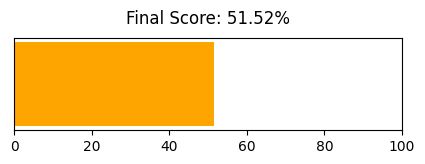

,🚨 Missing Required Skills
0,c
1,nlp
2,spark


In [33]:
# Run the evaluation
result = evaluate_resume_against_jd(resume_path, jd_path)

# Display pretty results
display_results(result)

In [34]:
!pip install streamlit pyngrok pdfplumber nltk spacy scikit-learn pandas numpy fuzzywuzzy python-docx
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [49]:
%%writefile app.py
import streamlit as st
import pdfplumber
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load SpaCy model once
@st.cache_resource
def load_spacy_model():
    return spacy.load("en_core_web_sm")

nlp = load_spacy_model()

st.set_page_config(page_title="Resume Relevance Checker", layout="wide")

st.title("📊 Resume Relevance Dashboard")

# Sidebar for file uploads
st.sidebar.header("Upload Files")
resume_file = st.sidebar.file_uploader("Upload Resume PDF", type="pdf")
jd_file = st.sidebar.file_uploader("Upload Job Description PDF", type="pdf")

# Function to extract text from PDF
@st.cache_data
def extract_pdf_text(file):
    with pdfplumber.open(file) as pdf:
        return "\n".join(page.extract_text() for page in pdf.pages)

# Process files
if resume_file and jd_file:
    resume_text = extract_pdf_text(resume_file)
    jd_text = extract_pdf_text(jd_file)

    # Show previews in tabs
    tabs = st.tabs(["Resume Preview", "JD Preview", "Skill Match", "Overall Score"])

    with tabs[0]:
        st.subheader("Resume")
        st.text_area("Preview", resume_text[:2000], height=300)

    with tabs[1]:
        st.subheader("Job Description")
        st.text_area("Preview", jd_text[:2000], height=300)

    with tabs[2]:
        st.subheader("Skill Match")
        # Extract keywords (simple approach)
        resume_words = set([token.text.lower() for token in nlp(resume_text) if token.is_alpha])
        jd_words = set([token.text.lower() for token in nlp(jd_text) if token.is_alpha])
        matched_skills = resume_words.intersection(jd_words)
        st.metric("Matched Keywords", len(matched_skills))
        st.write(matched_skills)

    with tabs[3]:
        st.subheader("Overall Relevance Score")
        # Simple cosine similarity for overall match
        vectorizer = TfidfVectorizer().fit([resume_text, jd_text])
        vectors = vectorizer.transform([resume_text, jd_text])
        score = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]
        st.metric("Relevance Score (%)", f"{score*100:.2f}")

Overwriting app.py


In [50]:
! pip install streamlit -q

In [46]:
!wget -q -O - ipv4.icanhazip.com

34.86.84.121


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501

⠙⠹

⠸⠼⠴⠦⠧⠇⠏
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.86.84.121:8501

⠋⠙⠹⠸⠼⠴⠦your url is: https://soft-hounds-kneel.loca.lt
